In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [63]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

In [64]:
# # Load data from a CSV file into a PandasDataset
# df = pd.read_csv(
#     "https://raw.githubusercontent.com/AileenNielsen/"
#     "TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv",
#     index_col=0,
#     parse_dates=True,
# )
# dataset = PandasDataset(df, target="#Passengers")

# # Split the data for training and testing
# training_data, test_gen = split(dataset, offset=-36)
# test_data = test_gen.generate_instances(prediction_length=12, windows=3)

# # Train the model and make predictions
# model = DeepAREstimator(
#     prediction_length=12, freq="M", trainer_kwargs={"max_epochs": 5}
# ).train(training_data)

# forecasts = list(model.predict(test_data.input))

# # Plot predictions
# plt.plot(df["1954":], color="black")
# for forecast in forecasts:
#   forecast.plot()
# plt.legend(["True values"], loc="upper left", fontsize="xx-large")
# plt.show()

In [65]:
device = 'cuda'

In [66]:
df = pd.read_csv('../../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

torch.manual_seed(42)

from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [67]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [68]:
first_piece['timestamps'] = first_piece.index
first_piece

/tmp/ipykernel_1014/4257701824.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_piece['timestamps'] = first_piece.index


,O2_avg,timestamps
2017-07-11 14:00:00,244.479760,2017-07-11 14:00:00
2017-07-11 14:05:00,245.013691,2017-07-11 14:05:00
2017-07-11 14:10:00,246.106549,2017-07-11 14:10:00
2017-07-11 14:15:00,244.890977,2017-07-11 14:15:00
2017-07-11 14:20:00,244.949879,2017-07-11 14:20:00
...,...,...
2017-07-12 05:40:00,237.429344,2017-07-12 05:40:00
2017-07-12 05:45:00,237.754546,2017-07-12 05:45:00
2017-07-12 05:50:00,237.742503,2017-07-12 05:50:00
2017-07-12 05:55:00,237.609201,2017-07-12 05:55:00


In [69]:
ds_one = PandasDataset(dataframes=first_piece, freq='5min', target='O2_avg', timestamp='timestamps')

In [70]:
# training_data, test_gen = split(ds_one, offset=-36)
# test_data = test_gen.generate_instances(prediction_length=12, windows=3)

# # Train the model and make predictions
# model = DeepAREstimator(
#     prediction_length=12, freq="M", trainer_kwargs={"max_epochs": 5}
# ).train(training_data)

# forecasts = list(model.predict(test_data.input))

# # Plot predictions
# plt.plot(df["1954":], color="black")
# for forecast in forecasts:
#   forecast.plot()
# plt.legend(["True values"], loc="upper left", fontsize="xx-large")
# plt.show()

In [71]:
# def highlight_entry(entry, color):
#     start = entry["start"]
#     end = entry["start"] + len(entry["target"])
#     plt.axvspan(start, end, facecolor=color, alpha=0.2)


# def plot_dataset_splitting(original_dataset, training_dataset, test_pairs):
#     for original_entry, train_entry in zip(original_dataset, training_dataset):
#         original_entry.plot()
#         highlight_entry(train_entry, "red")
#         plt.legend(["sub dataset", "training dataset"], loc="upper left")
#         plt.show()

#     for original_entry in original_dataset:
#         for test_input, test_label in test_pairs:
#             original_entry.plot()
#             highlight_entry(test_input, "green")
#             highlight_entry(test_label, "blue")
#             plt.legend(["sub dataset", "test input", "test label"], loc="upper left")
#             plt.show()

In [72]:
from gluonts.dataset.util import to_pandas

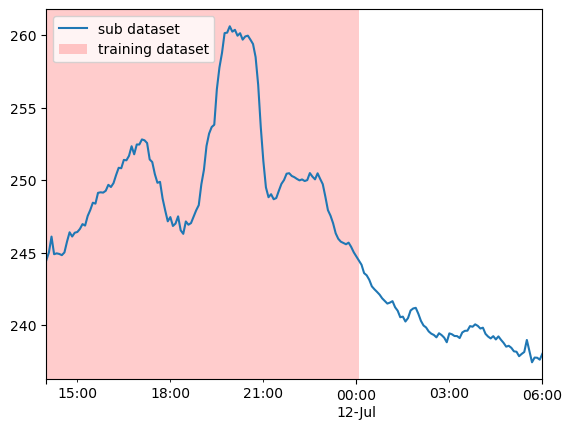

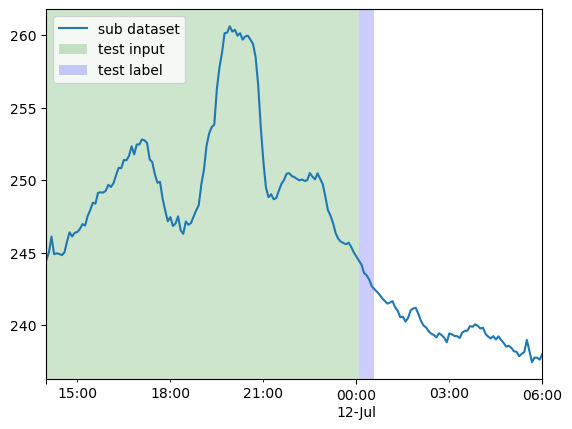

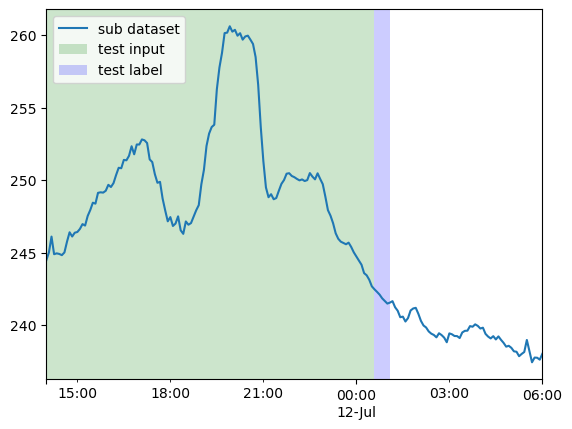

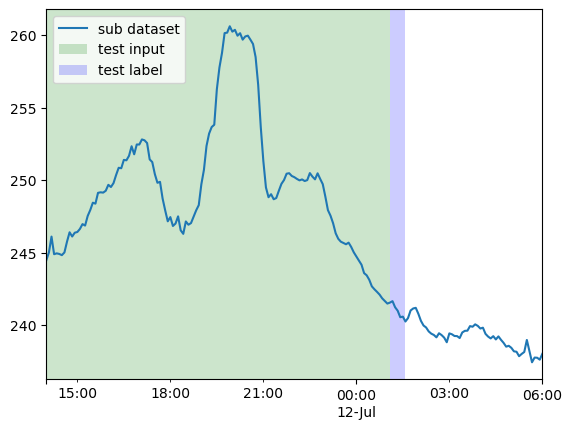

In [73]:
def _to_datetime_index(s_or_df):
    obj = s_or_df.copy()
    if isinstance(obj.index, pd.PeriodIndex):
        obj.index = obj.index.to_timestamp()  # cast to DatetimeIndex
    return obj

def highlight_entry(entry, color):
    # entry["start"] is a pandas.Period, entry["target"] is an array-like
    start_period = entry["start"]
    n = int(len(entry["target"]))
    # left = start of the first period, right = start of the period AFTER the last step
    left = start_period.to_timestamp()
    right = (start_period + n).to_timestamp()
    plt.axvspan(left, right, facecolor=color, alpha=0.2)

def plot_dataset_splitting(original_dataset, training_dataset, test_pairs):
    for original_entry, train_entry in zip(original_dataset, training_dataset):
        s = _to_datetime_index(to_pandas(original_entry))
        ax = s.plot()
        highlight_entry(train_entry, "red")
        ax.legend(["sub dataset", "training dataset"], loc="upper left")
        plt.show()

    for original_entry in original_dataset:
        for test_input, test_label in test_pairs:
            s = _to_datetime_index(to_pandas(original_entry))
            ax = s.plot()
            highlight_entry(test_input, "green")
            highlight_entry(test_label, "blue")
            ax.legend(["sub dataset", "test input", "test label"], loc="upper left")
            plt.show()
            
prediction_length = 6 # Preditct next 30 minutes
training_dataset, test_template = split(
    ds_one, date=pd.Period("2017-07-12 00:00:00", freq="5min")
)
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length,
    windows=3,
)

training_dataset
plot_dataset_splitting(ds_one, training_dataset, test_pairs)

In [ ]:
estimator = DeepAREstimator(
    freq="5min",
    prediction_length=prediction_length,
    trainer_kwargs={"max_epochs": 50}
)

predictor = estimator.train(training_dataset)

In [102]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
first_pair = next(iter(test_pairs))

forecast_it, ts_it = make_evaluation_predictions(
    dataset=first_pair,      # pass the TestData as-is
    predictor=predictor,
)

forecasts = list(forecast_it)   # materialize generators
labels   = list(ts_it)

evaluator = Evaluator(quantiles=(np.arange(20)/20.0)[1:])
agg_metrics, item_metrics = evaluator(labels, forecasts)


Running evaluation: 2it [00:00, 69.80it/s]
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - to python to disable frozen modules.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - make the debugger

In [106]:
agg_metrics

{'MSE': np.float64(4.177415878402563),
 'abs_error': np.float64(21.213078131198813),
 'abs_target_sum': np.float64(2933.5104478697776),
 'abs_target_mean': np.float64(244.45920398914816),
 'seasonal_error': np.float64(0.5170945829249503),
 'MASE': np.float64(1.5125476825378084),
 'MAPE': np.float64(0.007250366996522243),
 'sMAPE': np.float64(0.0072133703008464166),
 'MSIS': np.float64(19.497401568960452),
 'num_masked_target_values': np.float64(0.0),
 'QuantileLoss[0.05]': np.float64(3.203657587657415),
 'Coverage[0.05]': np.float64(0.16666666666666666),
 'QuantileLoss[0.1]': np.float64(11.728721487689132),
 'Coverage[0.1]': np.float64(0.5),
 'QuantileLoss[0.15]': np.float64(15.420281411385657),
 'Coverage[0.15]': np.float64(0.5),
 'QuantileLoss[0.2]': np.float64(18.28333960972374),
 'Coverage[0.2]': np.float64(0.5833333333333334),
 'QuantileLoss[0.25]': np.float64(19.70909135081348),
 'Coverage[0.25]': np.float64(0.75),
 'QuantileLoss[0.3]': np.float64(20.936825746623693),
 'Coverage[

In [107]:
item_metrics

,item_id,forecast_start,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,...,QuantileLoss[0.75],Coverage[0.75],QuantileLoss[0.8],Coverage[0.8],QuantileLoss[0.85],Coverage[0.85],QuantileLoss[0.9],Coverage[0.9],QuantileLoss[0.95],Coverage[0.95]
0,None,2017-07-11 23:35,0.908702,4.692781,1472.081862,245.346977,0.517095,1.512548,0.003189,0.003183,...,4.633927,1.0,4.233637,1.0,3.670752,1.0,3.094397,1.0,2.094528,1.0
1,None,2017-07-12 00:05,7.446130,16.520297,1461.428586,243.571431,NaN,NaN,0.011311,0.011243,...,10.173898,1.0,8.716505,1.0,6.976342,1.0,5.088846,1.0,2.912451,1.0


In [108]:
forecasts

[gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[247.04645, 248.72424, 245.46066, 245.21902, 246.05376, 246.30103],
        [245.37718, 246.49634, 246.43326, 243.37839, 245.71352, 245.17342],
        [246.09607, 243.79395, 247.33269, 246.16815, 247.45567, 246.22588],
        [249.27898, 244.6738 , 247.23764, 246.0574 , 247.95734, 245.62032],
        [248.2131 , 246.17067, 247.23605, 246.09882, 246.7333 , 256.9948 ],
        [244.76424, 244.20418, 247.21452, 245.44739, 246.15721, 247.14384],
        [247.52771, 246.24565, 245.81902, 249.14893, 246.54318, 242.79617],
        [253.57603, 244.79628, 256.68054, 246.02779, 258.42993, 245.63441],
        [246.18059, 245.73418, 247.48845, 245.61449, 246.49957, 246.96608],
        [245.85109, 243.41245, 246.47449, 246.99849, 248.18793, 245.75941],
        [245.54155, 245.80202, 248.7082 , 247.65038, 246.58125, 244.51688],
        [245.27953, 246.11261, 247.36534, 246.74223, 253.53088, 246.4218 ],
        [245.9481

In [136]:
len(forecasts)

2

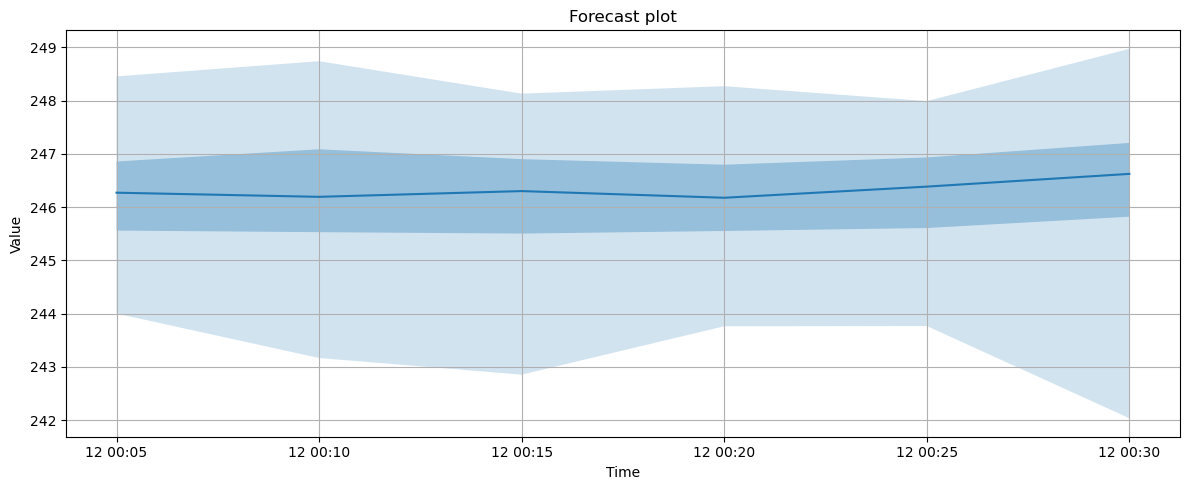

In [142]:
plt.figure(figsize=(12, 5))
forecasts[1].plot()   # you can change or omit the intervals
plt.title("Forecast plot")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()